# Understanding the Dataset

Our dataset is derived from PhysioNet, a physiological signal feature library. PhysioNet provides 10-second sample ECG signals for a variety of medical and research applications. However, for this specific dataset, resampling was performed, extracting only 1 of the original 10 seconds of recorded heartbeats; This approach allows creating a more compact and focused dataset, maintaining the representativeness of heartbeats for arrhythmia analysis.

Our outputs has five categories: 

• N: Normal beat - 0

• S: Supraventricular premature beat - 1

• V: Premature ventricular contraction - 2

• F: Fusion of ventricular and normal beat - 3

• Q: Unclassifiable beat - 4

The ECG was generated using 125Hz, that means that we need 125 features to have 1s. Our Dataset have 188 columns, that means 187 columns features.
In this way, we have 187/125 = 1.496s. It's like taking just one heart beat from entire ECG.

It's well know that ECG data can have noises in the signal. Our dataset doesn't have noise, so our model won't be able to generalize for all kind of ECG's

### Imports 

In [107]:
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Layer, Input, Lambda, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, Dropout, Dense, GlobalAveragePooling1D, Softmax, Flatten
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from random import randint
import itertools

## Reading the Dataset

In [61]:
# Load the dataset with pandas
train_df = pd.read_csv('dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('dataset/mitbih_test.csv', header=None)

In [114]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [117]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [53]:
if True not in train_df.isna(): print("Dataset without NaN")

Dataset without NaN


In [54]:
if True not in test_df.isna(): print("Dataset without NaN")

Dataset without NaN


In [50]:
yValues = train_df[187].value_counts()
yValues

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

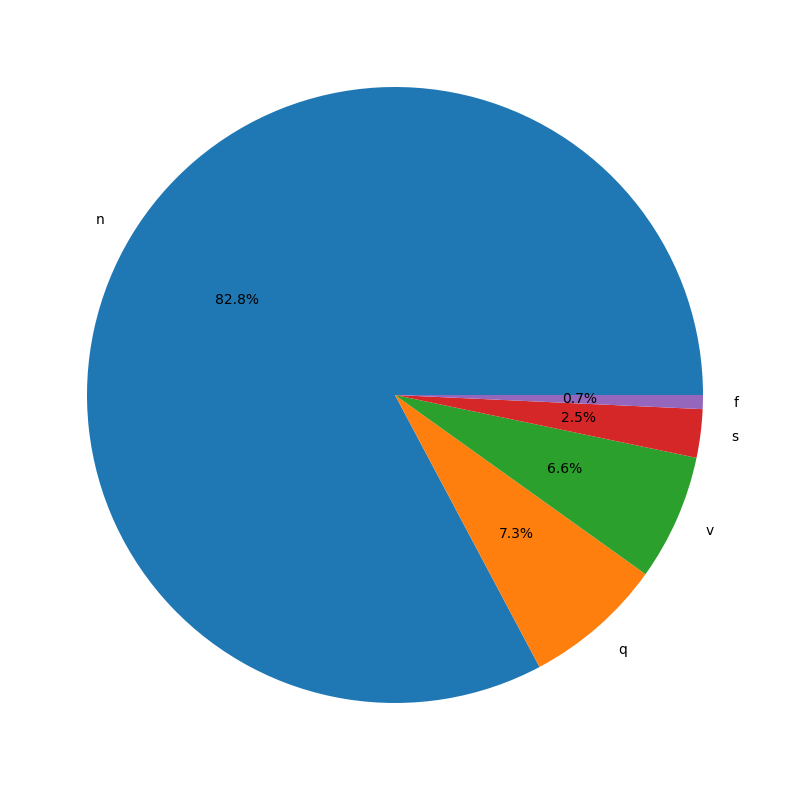

In [60]:
plt.figure(figsize=(20,10))
plt.pie(yValues, labels=['n','q','v','s','f'], autopct='%1.1f%%')
plt.show()

<AxesSubplot: xlabel='187', ylabel='count'>

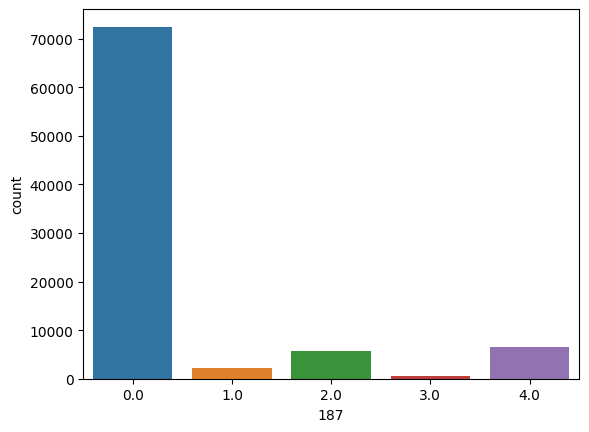

In [65]:
sns.countplot(x=187, data = train_df) 

### Interpreting the graph

It can be seen that our dataset has the samples corresponding to each category in an unbalanced way. Around 82.8% of our samples have a normal heartbeat, while only a very small portion represents abnormal heartbeats. To avoid bias in our data, we will use resample to pre-process our data.

In [112]:
# Doing a resample in all categories from 1 to 4
dfs = [resample(train_df[train_df[187] == i], replace = True, n_samples = 20000, random_state = randint(130, 150)) for i in range(0, 5)]

train_df_sampled = pd.concat(dfs)

yValues_sampled = train_df_sampled[187].value_counts()
yValues_sampled

0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: 187, dtype: int64

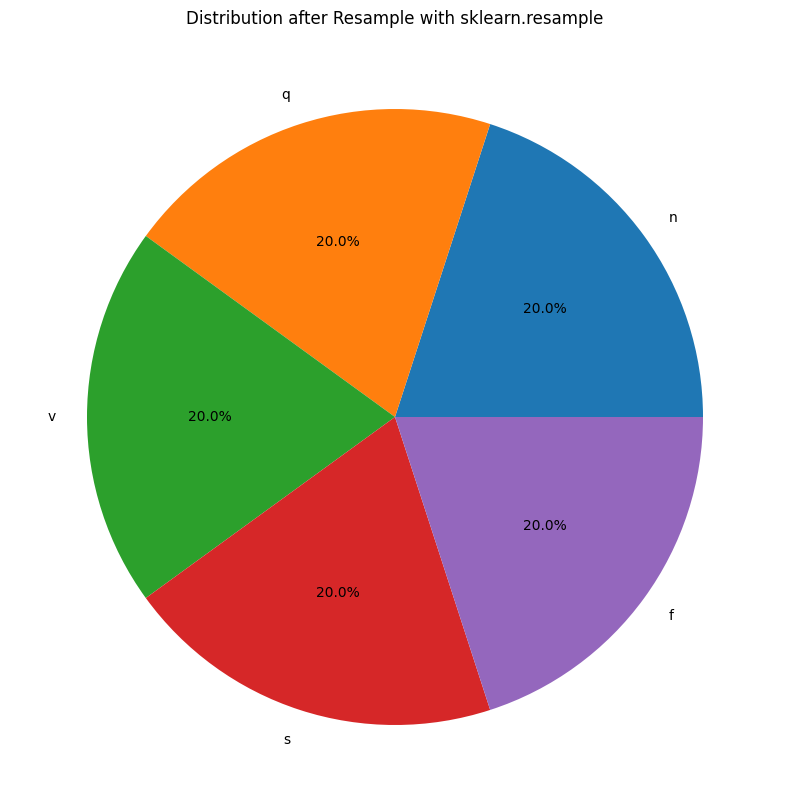

In [80]:
plt.figure(figsize=(20,10))
plt.pie(yValues_sampled, labels=['n','q','v','s','f'], autopct='%1.1f%%')
plt.title('Distribution after Resample with sklearn.resample')
plt.show()

Now that our dataset is balanced, let's explore more about each category. We will take one random sample from each category

In [82]:
unique_c_sample = train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
unique_c_sample

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
45122,1.000000,0.764706,0.036053,0.047438,0.055028,0.079696,0.136622,0.123340,0.140417,0.129032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73496,0.925831,0.744246,0.135550,0.079284,0.173913,0.255754,0.265985,0.289003,0.291560,0.301790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76061,1.000000,0.984724,0.810811,0.497062,0.415981,0.379553,0.352526,0.325499,0.317274,0.305523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80918,1.000000,0.806540,0.564033,0.316076,0.189373,0.208447,0.196185,0.173025,0.152589,0.147139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
85870,1.000000,0.819355,0.474194,0.261290,0.119355,0.090323,0.093548,0.093548,0.090323,0.096774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


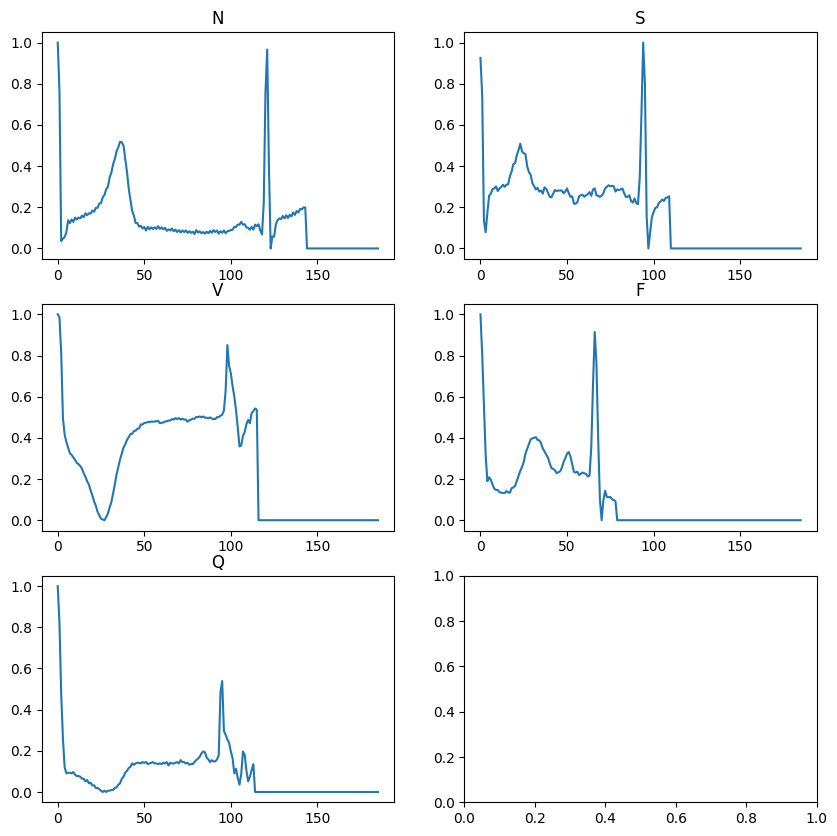

In [89]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0][0].plot(unique_c_sample.iloc[0,:186])
ax[0][1].plot(unique_c_sample.iloc[1,:186])
ax[1][0].plot(unique_c_sample.iloc[2,:186])
ax[1][1].plot(unique_c_sample.iloc[3,:186])
ax[2][0].plot(unique_c_sample.iloc[4,:186])

ax[0][0].set_title("N")
ax[0][1].set_title("S")
ax[1][0].set_title("V")
ax[1][1].set_title("F")
ax[2][0].set_title("Q")

plt.show()

I'm not an expert on ECG, so it's hard to give a meaningful insight about this plots, but is interesting to see that 3/4 of anormal beats has quick and prolonged decrease of signal. Further investigation is needed. 

# Building our CNN model with ResNet

To build our Convolutional Neural Network, we will use Keras (a library based on TensorFlow).

First we need to separete our features from the outputs and we need convert our output to categorical data

In [113]:
# Separating the features from the outputs
X_train = train_df_sampled.iloc[:, :-1].values  
y_train = train_df_sampled.iloc[:, -1].values  

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Transform the output in categorical values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Making the Residual Block

The architeture of CNN ResNet is given by:

Input -> Conv1D|BN|ReLU -> Conv1D|BN|ReLu|Dropout|Conv1D -> Residual Block * n -> BN|ReLu|Dense|softmax

In [100]:
def residual_block(x, filters, kernel_size=16, stride=1):
    
    # Main pathway
    shortcut = x  # Saves the enter for main connection

    # First sublayer
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)

    # Second sublayer
    x = BatchNormalization()(x)
    x = ReLU()(x)
    X = Dropout(0.5)(x)
    x = Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)

    # Residual connection
    if x.shape[-1] != shortcut.shape[-1] or stride != 1:
        # Adjust the dimension of shortcut if is different of x or if stride > 1
        shortcut = Conv1D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)

    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_classes, num_blocks, num_filters):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Add Residual Block
    for i in range(num_blocks):
        stride = 2 if i % 2 == 0 else 1  # Apply stride to each second block
        x = residual_block(x, num_filters, stride=stride)
        num_filters *= 2  # Double the filter number

    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def train_model(model, X_train, y_train, validation_data, epochs = 10):
    
    history = model.fit(X_train, y_train, epochs = epochs, validation_data=validation_data)
    
    return (model, history)

def evaluate_model(history, X_test, y_test,model):
    
    scores = model.evaluate((X_test), y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [93]:
model3 = build_model((187, 1), 5, 4, 16)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_60 (Conv1D)             (None, 187, 64)      448         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_47 (BatchN  (None, 187, 64)     256         ['conv1d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_47 (ReLU)                (None, 187, 64)      0           ['batch_normalization_47[0]

In [98]:
model3_fit = train_model(model3, X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3125/3125 [==============================] - 652s 207ms/step - loss: 0.3148 - accuracy: 0.8923 - val_loss: 0.1544 - val_accuracy: 0.9486
Epoch 2/10
3125/3125 [==============================] - 656s 210ms/step - loss: 0.1213 - accuracy: 0.9583 - val_loss: 0.1847 - val_accuracy: 0.9401
Epoch 3/10
3125/3125 [==============================] - 760s 243ms/step - loss: 0.0838 - accuracy: 0.9719 - val_loss: 0.1619 - val_accuracy: 0.9472
Epoch 4/10
3125/3125 [==============================] - 609s 195ms/step - loss: 0.0625 - accuracy: 0.9794 - val_loss: 0.1511 - val_accuracy: 0.9520
Epoch 5/10
3125/3125 [==============================] - 678s 217ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.2896 - val_accuracy: 0.9139
Epoch 6/10
3125/3125 [==============================] - 665s 213ms/step - loss: 0.0395 - accuracy: 0.9871 - val_loss: 0.0933 - val_accuracy: 0.9744
Epoch 7/10
3125/3125 [==============================] - 616s 197ms/step - loss: 0.0328 - accuracy: 0.9894 - val_

In [105]:
print(model3_fit[0])

Accuracy: 97.50%


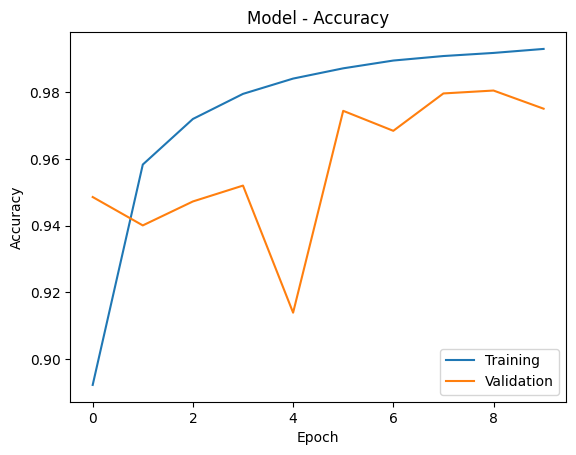

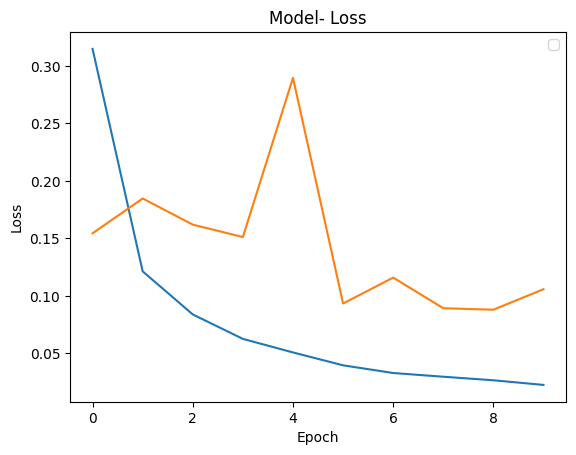

685/685 [==============================] - 39s 56ms/step


In [108]:
evaluate_model(model3_fit[1], X_test, y_test, model3_fit[0])

685/685 [==============================] - 199s 291ms/step


<AxesSubplot: >

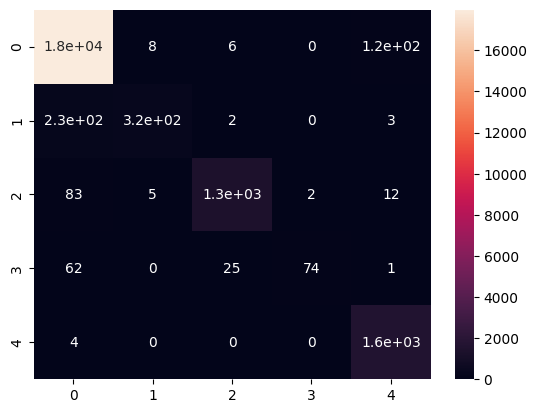

In [111]:
y_pred=model.predict(X_test)

# Compute confusion matrix
cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(cf_matrix, annot=True)

C:\Users\carlos23001\AppData\Local\Temp\ipykernel_33504\747908089.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(cf_matrix / cf_matrix.astype(np.float).sum(axis=1), annot=True)


<AxesSubplot: >

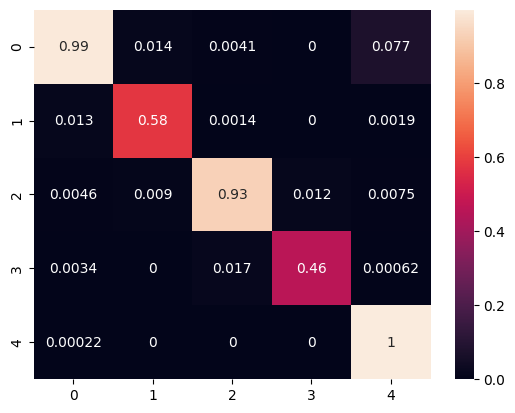

In [120]:
sns.heatmap(cf_matrix / cf_matrix.astype(np.float).sum(axis=1), annot=True)

# Conclusions 

We show that even with a initial low filter, we can obtain an excellent results. Our matrix confunsion shows that just 1% of predict values classified to a normal beat without be a normal beat.
